--- Método B: Análisis---

Parámetros de inflexión:
  Derivada máxima (m)         = 39032.8889 V/s
  Tiempo de inflexión (t_inf) = 0.10 s
  Voltaje de inflexión (y_inf) = 16.892 V

Tiempos calculados (método de la tangente):
  t_L (intersección inferior) = 0.1001 s
  t_T (intersección superior) = 0.1002 s

--- PARÁMETROS FOPDT OBTENIDOS ---
  K = -131.2500
  L = 0.0001 s
  T = 0.0001 s


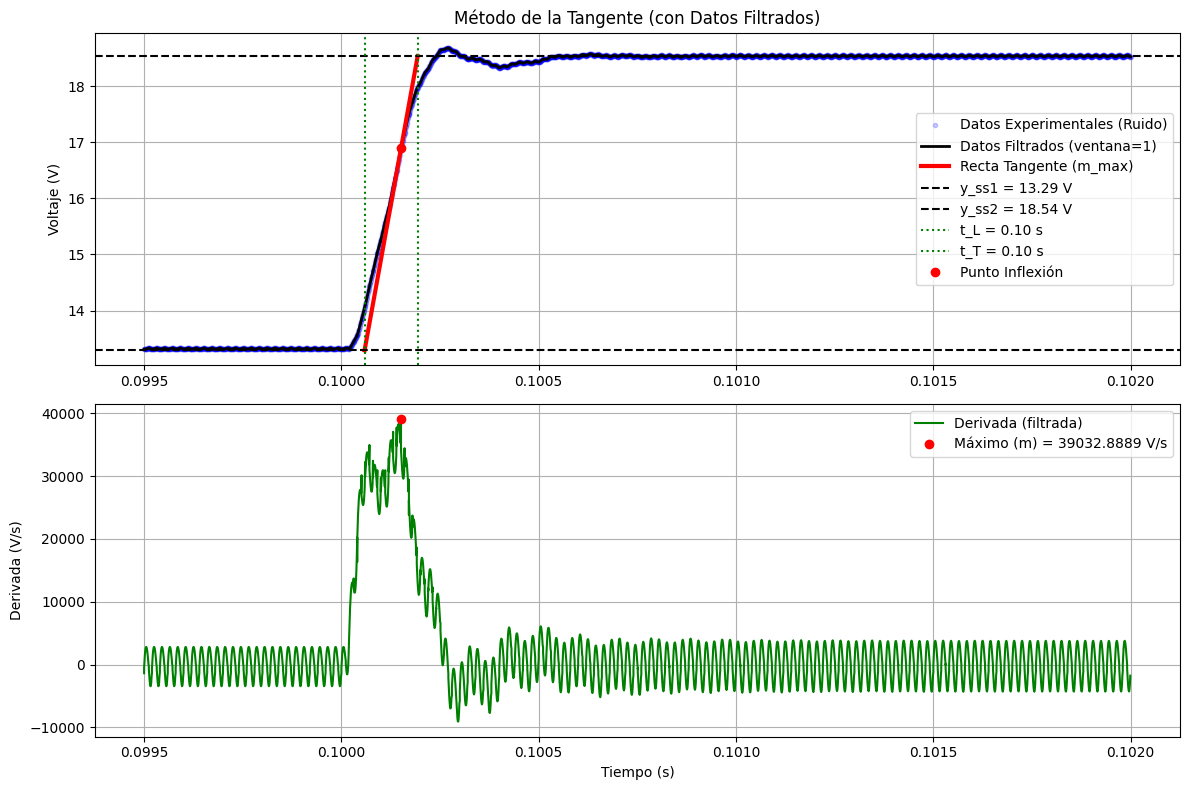

In [49]:
# Código PARA EL MÉTODO B.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# --- Nombre del archivo (debe estar en la misma carpeta de este script) ---
nombre_archivo = 'resultadosM1.txt'

# --- Parámetros del experimento (REEMPLAZAR CON SUS VALORES) ---
y_ss1 = 13.29     # Voltaje de estado estacionario inicia.
y_ss2 = 18.54     # Voltaje de estado estacionario final.
delta_u = -0.04    # Cambio en la entrada.


# --- Tiempo del escalón (REEMPLAZAR CON SUS VALORES) ---
# Es el primer valor de tiempo que el Monitor Serie imprime inmediatamente después de que aparece el mensaje --- ESCALÓN APLICADO (40%) ---
t_0 = 0.10       # Nota: Convertir el valor de ms a segundos.

# --- Ventana del filtro  (Puedes ajustar este valor si es necesario, 5 o 7 es un buen inicio) ---
window_size = 1


try:
    # --- 1. Importar datos (Tiempo, ValorADC) ---
    # Usamos pandas para cargar, luego convertimos a NumPy.
    data = pd.read_csv(nombre_archivo, header=None, names=['Tiempo_s', 'Valor'])
    
 
    # --- 2. Convertir ADC a Voltaje y aplica el filtro ---   
    # Convertir a Series de pandas
    data['t_seg'] = data['Tiempo_s']
    data['y_voltaje_ruido'] = data['Valor']

    # Aplicar un filtro de media móvil para suavizar el ruido
    data['y_voltaje_filtrado'] = data['y_voltaje_ruido'].rolling(window=window_size, center=True).mean()
    
    # Descartar las filas con NaN (generadas en los bordes por el filtro)
    data = data.dropna()
    
    # Ahora convertir a arrays de NumPy para los cálculos
    t_seg = data['t_seg'].to_numpy()
    y_voltaje_ruido = data['y_voltaje_ruido'].to_numpy()       # Voltaje original
    y_voltaje_filtrado = data['y_voltaje_filtrado'].to_numpy() # Voltaje filtrado
    

    # --- 3. Calcular la derivada sobre datos filtrados ---
    # np.diff() calcula la diferencia entre elementos consecutivos (ej. y[1]-y[0])
    dy = np.diff(y_voltaje_filtrado)
    dt = np.diff(t_seg)
    
    # Evitar división por cero si el tiempo entre muestras es 0 al asignar un valor muy pequeño
    dt[dt == 0] = 1e-9
    
    derivada = dy / dt
    
    # El array 'derivada' tiene N-1 elementos.
    # Asociamos la derivada[i] al tiempo[i] (el inicio del intervalo)
    t_derivada = t_seg[:-1] # Todos los tiempos excepto el último


    # --- 4. Encontrar el punto de inflexión (derivada máxima) ---
    m = np.max(derivada)            # (m) Valor de la derivada máxima
    idx_max = np.argmax(derivada)   # Índice (posición) donde ocurre el máximo
    
    t_inflexion = t_derivada[idx_max] # Tiempo en el que ocurre m
    
    y_inflexion = y_voltaje_filtrado[idx_max]


    # --- 5. Calcular L y T analíticamente (Método de Ziegler-Nichols) ---
    # Calcular las intersecciones de la recta tangente
    t_L = t_inflexion + (y_ss1 - y_inflexion) / m
    t_T = t_inflexion + (y_ss2 - y_inflexion) / m
    
    # Calcular los parámetros L y T
    L = t_L - t_0
    T = t_T - t_L
    
    # Calcular la Ganancia K
    K = (y_ss2 - y_ss1) / delta_u

    # --- 6. Impresión de Resultados ---
    print(f"--- Método B: Análisis---")
    
    print("\nParámetros de inflexión:")
    print(f"  Derivada máxima (m)         = {m:.4f} V/s")
    print(f"  Tiempo de inflexión (t_inf) = {t_inflexion:.2f} s")
    print(f"  Voltaje de inflexión (y_inf) = {y_inflexion:.3f} V")
    
    print("\nTiempos calculados (método de la tangente):")
    print(f"  t_L (intersección inferior) = {t_L:.4f} s")
    print(f"  t_T (intersección superior) = {t_T:.4f} s")

    print("\n--- PARÁMETROS FOPDT OBTENIDOS ---")
    print(f"  K = {K:.4f}")
    print(f"  L = {L:.4f} s")
    print(f"  T = {T:.4f} s")


    # --- 7. Visualización en la gráfica. ---
    # Calcular la línea tangente para graficarla
    b_tangente = y_inflexion - m * t_inflexion
    t_graf_tangente = np.array([t_L, t_T])
    y_graf_tangente = m * t_graf_tangente + b_tangente

    plt.figure(figsize=(12, 8))
    
    # Gráfica 1: Datos y Tangente
    # Graficamos los datos originales (con ruido) Y los datos filtrados
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(t_seg, y_voltaje_ruido, 'b.', label='Datos Experimentales (Ruido)', alpha=0.2)
    ax1.plot(t_seg, y_voltaje_filtrado, 'k-', linewidth=2, label=f'Datos Filtrados (ventana={window_size})')
    
    ax1.plot(t_graf_tangente, y_graf_tangente, 'r-', linewidth=3, label='Recta Tangente (m_max)')
    ax1.axhline(y=y_ss1, color='k', linestyle='--', label=f'y_ss1 = {y_ss1} V')
    ax1.axhline(y=y_ss2, color='k', linestyle='--', label=f'y_ss2 = {y_ss2} V')
    ax1.axvline(x=t_L, color='g', linestyle=':', label=f't_L = {t_L:.2f} s')
    ax1.axvline(x=t_T, color='g', linestyle=':', label=f't_T = {t_T:.2f} s')
    ax1.plot(t_inflexion, y_inflexion, 'ro', markersize=6, label='Punto Inflexión')
    
    ax1.set_title('Método de la Tangente (con Datos Filtrados)')
    ax1.set_ylabel('Voltaje (V)')
    ax1.legend()
    ax1.grid(True)

    # Gráfica 2: Derivada
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.plot(t_derivada, derivada, 'g-', label='Derivada (filtrada)') 
    ax2.plot(t_inflexion, m, 'ro', markersize=6, label=f'Máximo (m) = {m:.4f} V/s')
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylabel('Derivada (V/s)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{nombre_archivo}'")
    print("Por favor, asegúrese que el archivo .txt está en la misma carpeta que el script.")
    
except Exception as e:
    print(f"Ha ocurrido un error inesperado: {e}")


Función de Transferencia del Modelo (FOPDT):
         -131.25 * e^(-0.0001s)
  G(s) = ------------
         0.0001s + 1



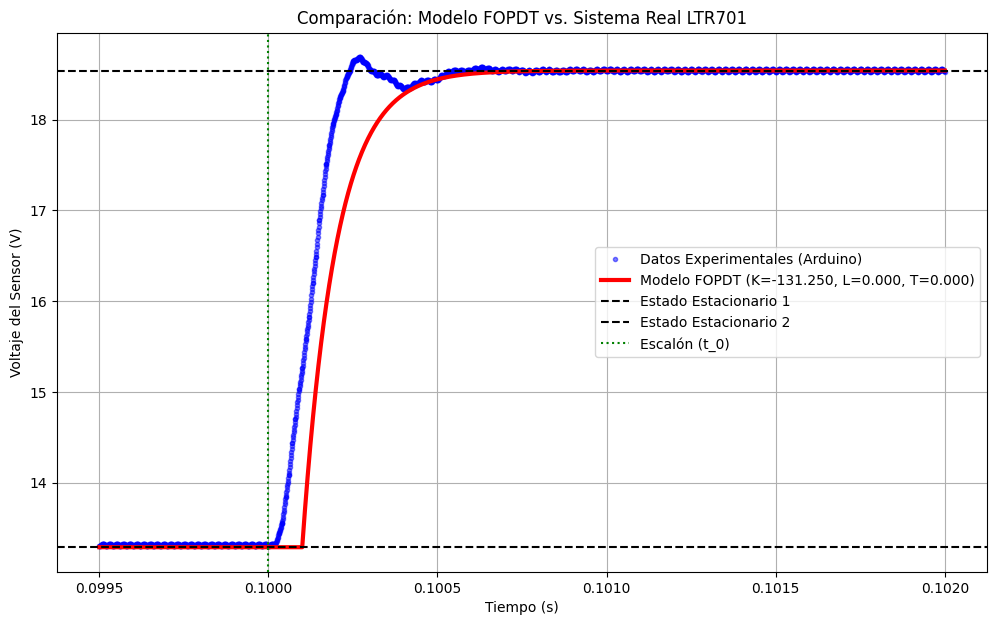

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parámetros del archivo
nombre_archivo = 'resultadosM1.txt'

# --- Parámetros obtenidos del análisis (REEMPLAZAR CON SUS VALORES) ---
K = -131.250
L = 0.0001      # Tiempo muerto (s)
T = 0.0001      # Constante de tiempo (s)

# --- Parámetros del experimento (REEMPLAZAR CON SUS VALORES) ---
y_ss1 = 13.29     # Voltaje de estado estacionario inicia.
y_ss2 = 18.54     # Voltaje de estado estacionario final.
delta_u = -0.04    # Cambio en la entrada.

# --- Tiempo del escalón (REEMPLAZAR CON SUS VALORES) ---
# Es el primer valor de tiempo que el Monitor Serie imprime inmediatamente después de que aparece el mensaje --- ESCALÓN APLICADO (40%) ---
t_in = 0.10      # Nota: Convertir el valor de ms a segundos.

# --- Definir e imprimir la Función de Transferencia (FT) ---
print("\n" + "="*40)
print("Función de Transferencia del Modelo (FOPDT):")
print(f"         {K} * e^(-{L}s)")
print(f"  G(s) = {'-' * (len(str(T)) + 6)}")
print(f"         {T}s + 1")
print("="*40 + "\n")


try:
    # Cargar datos del Arduino (Tiempo en ms, Valor ADC)
    data = pd.read_csv(nombre_archivo, header=None, names=['Tiempo_ms', 'Valor_ADC'])
    
    # Convertir a segundos y voltaje
    t_exp = data['Tiempo_ms']
    y_exp = data['Valor_ADC'] # Convertir ADC a Voltaje
    

    t_0 = t_exp[t_exp > t_in].iloc[0] # Encuentra el tiempo del escalón (ej. 50s)

    # --- Crear la respuesta del modelo FOPDT ---
    t_sim = t_exp.copy()
    y_sim = np.zeros_like(t_sim)

    for i, t in enumerate(t_sim):
        if t < (t_0 + L):
            y_sim[i] = y_ss1
        else:
            # Ecuación de respuesta al escalón de un FOPDT
            # y = y_inicial + (Ganancia_Total) * (1 - e^(-(t - t_escalon - L) / T))
            y_sim[i] = y_ss1 + (K * delta_u) * (1 - np.exp(-(t - t_0 - L) / T))
            
            # Limitar la respuesta al valor final por si el modelo sobrepasa
            if y_sim[i] > y_ss2:
                y_sim[i] = y_ss2

    # --- Graficar la comparación ---
    plt.figure(figsize=(12, 7))
    plt.plot(t_exp, y_exp, 'b.', label='Datos Experimentales (Arduino)', alpha=0.5)
    plt.plot(t_sim, y_sim, 'r-', linewidth=3, label=f'Modelo FOPDT (K={K:.3f}, L={L:.3f}, T={T:.3f})')
    plt.axhline(y=y_ss1, color='k', linestyle='--', label='Estado Estacionario 1')
    plt.axhline(y=y_ss2, color='k', linestyle='--', label='Estado Estacionario 2')
    plt.axvline(x=t_0, color='g', linestyle=':', label='Escalón (t_0)')
    
    plt.title('Comparación: Modelo FOPDT vs. Sistema Real LTR701')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Voltaje del Sensor (V)')
    plt.legend()
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print(f"Error: No se encontró el archivo {nombre_archivo}")
    print("Por favor, guarde sus datos del Arduino con ese nombre en la misma carpeta.")

In [52]:
# Importar las bibliotecas necesarias
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Parámetros del sistema de temperatura LTR701 (Obtenidos en la práctica anterior) ---
# (REEMPLACE CON SUS VALORES)
K = -131.250
L = 0.0001      # Tiempo muerto (s)
T = 0.0001      # Constante de tiempo (s)

# --- 2. Creación del Modelo de la Planta Gp(s) ---

# La simulación en Python no maneja el retardo e^{-Ls} de forma nativa en tf.
# Usamos una "Aproximación de Padé" de primer orden, que es un estándar
# para simular el retardo de tiempo.
pade_delay = ct.tf(*ct.pade(L, n=1)) # n=1 es el orden de la aproximación

# Creamos la FT de la planta (sin el retardo)
Gp_no_delay = ct.tf([K], [T, 1])

# Multiplicamos para obtener la planta completa
Gp = Gp_no_delay * pade_delay

print("Función de Transferencia de la Planta (con aproximación de Padé):")
print(Gp)

Función de Transferencia de la Planta (con aproximación de Padé):
<TransferFunction>: sys[58]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

    131.2 s - 2.625e+06
  ------------------------
  0.0001 s^2 + 3 s + 2e+04


In [53]:
# --- 2. Definición de Setpoint y Voltajes de Operación ---
V_ref = 18.54    # Voltaje objetivo (corresponde a 35°C)
V_base = 13.30   # Voltaje inicial (corresponde a 25°C)

# El tamaño del escalón que simulamos es la diferencia
step_size = V_ref - V_base

print(f"Voltaje de Referencia (Setpoint): {V_ref:.2f} V")
print(f"Voltaje Inicial (Línea Base): {V_base:.2f} V")
print(f"Tamaño del Escalón a simular: {step_size:.2f} V")

Voltaje de Referencia (Setpoint): 18.54 V
Voltaje Inicial (Línea Base): 13.30 V
Tamaño del Escalón a simular: 5.24 V


In [54]:
# --- 3. Cálculo de Ganancias PID "Raw" (Ziegler-Nichols) ---

# Aplicamos las fórmulas de la tabla para un PID
Kp_zn = (1.2 * T) / (K * L)
Ti_zn = 2 * L
Td_zn = 0.5 * L

# Convertimos a las ganancias Kp, Ki, Kd
Ki_zn = Kp_zn / Ti_zn
Kd_zn = Kp_zn * Td_zn

print("--- Ganancias Iniciales (Ziegler-Nichols) ---")
print(f"Kp = {Kp_zn:.4f}")
print(f"Ki = {Ki_zn:.4f}")
print(f"Kd = {Kd_zn:.4f}")

--- Ganancias Iniciales (Ziegler-Nichols) ---
Kp = -0.0091
Ki = -45.7143
Kd = -0.0000


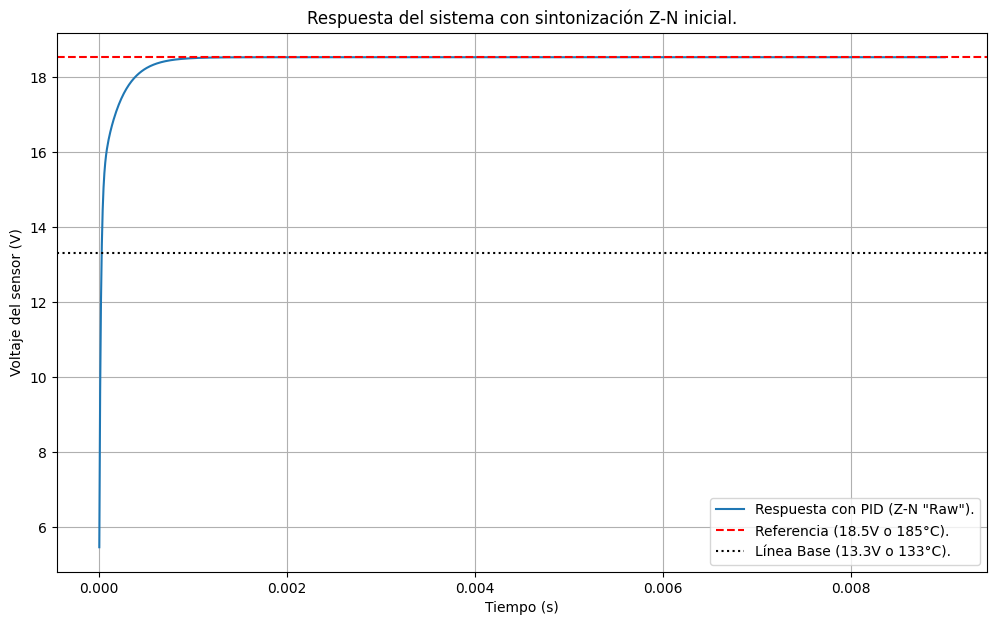


Información de la respuesta (escalón unitario):
  - Sobreimpulso (Overshoot): 0.00%
  - Tiempo de Establecimiento (SettlingTime): 0.00 s


In [40]:
# --- 4. Creación del Controlador PID y Simulación ---

# FT del controlador PID (Numerador=[Kd, Kp, Ki], Denominador=[1, 0])
Gc_zn = ct.tf([Kd_zn, Kp_zn, Ki_zn], [1, 0])

# Sistema en Lazo Cerrado
sistema_cl_zn = ct.feedback(Gc_zn * Gp, 1)

# Simulación de la respuesta al escalón.
# ct.step_response calcula la respuesta a un escalón de magnitud 1.
t_sim, y_unit_step = ct.step_response(sistema_cl_zn, T=np.linspace(0, 0.009, 1000))

# --- Escalamos la respuesta ---
# La respuesta real es el cambio (y_unit_step * step_size) sumado al valor inicial (V_base)
y_zn = (y_unit_step * step_size) + V_base

# --- Graficación ---
plt.figure(figsize=(12, 7))
plt.plot(t_sim, y_zn, label='Respuesta con PID (Z-N "Raw").')

# La referencia (setpoint) ahora es V_ref
plt.axhline(y=V_ref, color='r', linestyle='--', label=f'Referencia ({V_ref:.1f}V o {V_ref*10:.0f}°C).')
plt.axhline(y=V_base, color='k', linestyle=':', label=f'Línea Base ({V_base:.1f}V o {V_base*10:.0f}°C).')
plt.title('Respuesta del sistema con sintonización Z-N inicial.')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje del sensor (V)')
plt.legend()
plt.grid(True)
plt.show()

# Imprimir información de la respuesta
# ct.step_info es para un escalón unitario, por lo que lo usamos con y_unit_step
info = ct.step_info(sistema_cl_zn) 
print("\nInformación de la respuesta (escalón unitario):")
print(f"  - Sobreimpulso (Overshoot): {info['Overshoot']:.2f}%")
print(f"  - Tiempo de Establecimiento (SettlingTime): {info['SettlingTime']:.2f} s")